In [ ]:
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from scipy.stats import norm, t

In [ ]:
df = pd.read_csv('/home/hk/courses/cgs698c/data/twoGroup.csv', dtype={'Group':'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Score   120 non-null    int64   
 1   Group   120 non-null    category
dtypes: category(1), int64(1)
memory usage: 1.3 KB


In [ ]:
df.head()

,Score,Group
0,102,Smart Drug
1,107,Smart Drug
2,92,Smart Drug
3,101,Smart Drug
4,110,Smart Drug


In [ ]:
df.tail()

,Score,Group
115,138,Placebo
116,99,Placebo
117,93,Placebo
118,93,Placebo
119,72,Placebo


In [ ]:
df.groupby('Group').agg(['mean', 'std'])

Score           
                  mean        std
Group                            
Placebo     100.035088  17.894497
Smart Drug  107.841270  25.445201

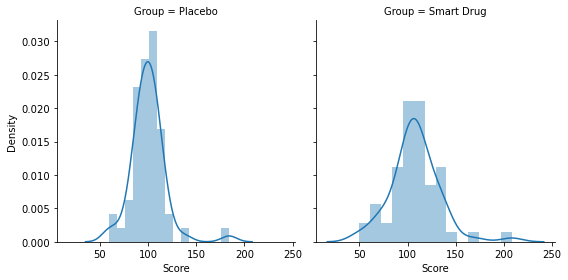

In [ ]:
fg = sns.FacetGrid(df, col='Group', height=4)
fg.map(sns.distplot, 'Score');

In [ ]:
y = df['Score'][df.Group == 'Smart Drug']#the data - only the smart group is needed

In [ ]:
with pm.Model() as model:
    mu = pm.Normal('mu', y.mean(), sd=y.std())
    sigma = pm.Uniform('sigma', y.std()/1000, y.std()*1000)
    
    # PyMC's Normal likelihood can take either precision or standard deviation as an argument.
    likelihood = pm.Normal('likelihood', mu, sd=sigma, observed=y)


In [ ]:
with model:
    tr = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 6 seconds.


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

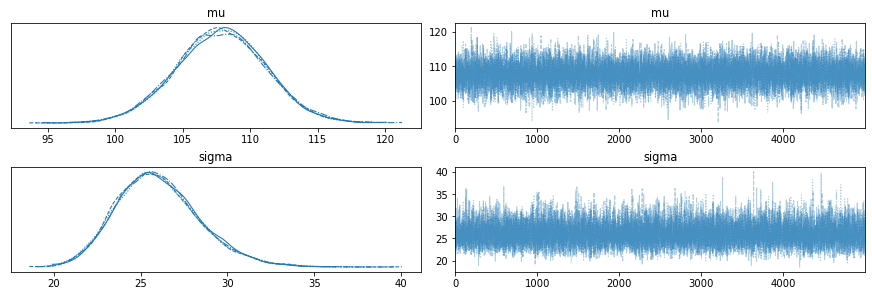

In [ ]:
az.plot_trace(tr)

array([<AxesSubplot:title={'center':'mu'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

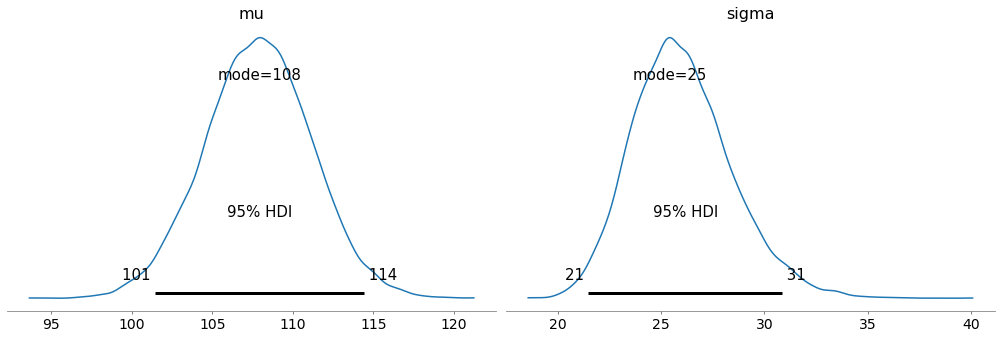

In [ ]:
az.plot_posterior(tr,['mu','sigma'], hdi_prob=0.95, point_estimate='mode')

<AxesSubplot:title={'center':'x'}>

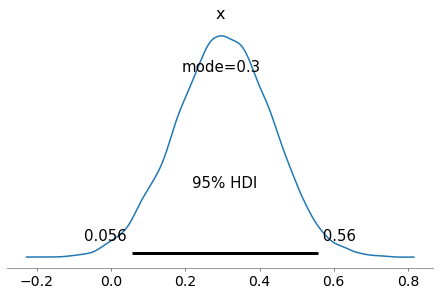

In [ ]:
az.plot_posterior((tr['mu']-100.0)/tr['sigma'], hdi_prob=0.95, point_estimate='mode') #Effect size

In [ ]:
#Since data has some outliers try with a t-distribution
with pm.Model() as model2:
    mu = pm.Normal('mu', y.mean(), sd=y.std())
    sigma = pm.Uniform('sigma', y.std()/1000, y.std()*1000)
    nu_minus1 = pm.Exponential('nu_minus1', 1/29)
    nu = pm.Deterministic('nu', nu_minus1+1)
    
    likelihood = pm.StudentT('likelihood', nu,  mu, sd=sigma, observed=y)

In [ ]:
with model2:
    tr2 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus1, sigma, mu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 8 seconds.


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'nu_minus1'}>,
        <AxesSubplot:title={'center':'nu_minus1'}>],
       [<AxesSubplot:title={'center':'nu'}>,
        <AxesSubplot:title={'center':'nu'}>]], dtype=object)

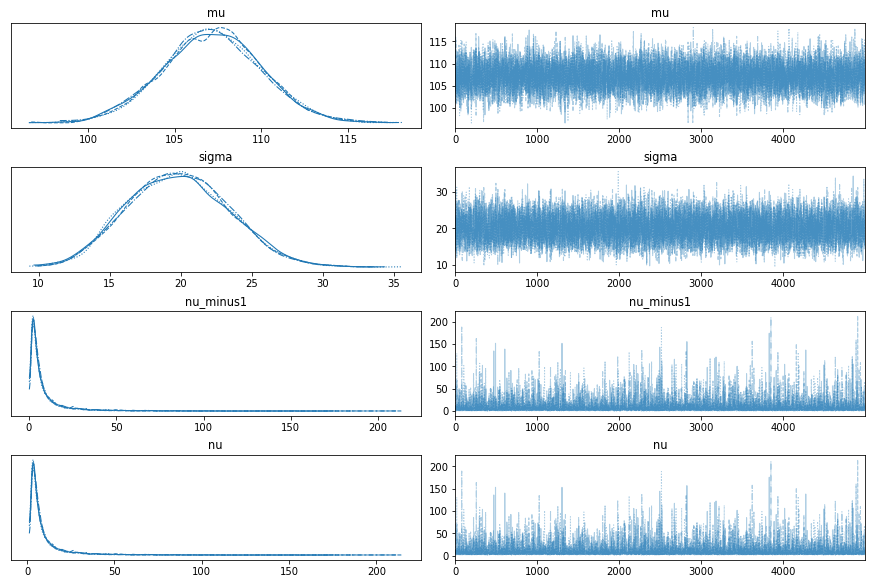

In [ ]:
az.plot_trace(tr2)

array([<AxesSubplot:title={'center':'mu'}>,
       <AxesSubplot:title={'center':'sigma'}>,
       <AxesSubplot:title={'center':'nu'}>], dtype=object)

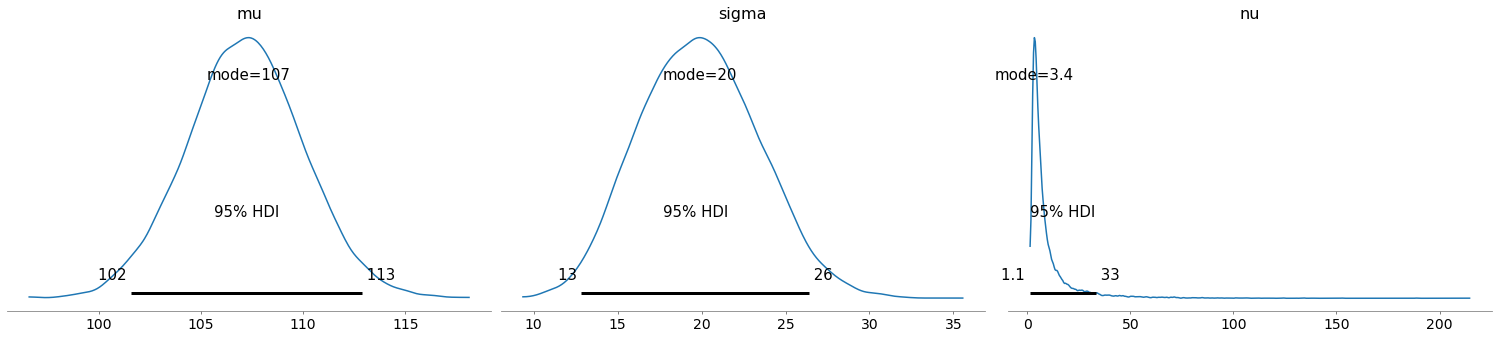

In [ ]:
az.plot_posterior(tr2,['mu','sigma','nu'], hdi_prob=0.95, point_estimate='mode')